In [13]:
import pandas as pd
import numpy as np
import geopandas as gpd
import momepy as mp
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import src.plot_geo

import dask_geopandas as dgp

plt.style.use('../styles/matplotlib-stylesheets/pitayasmoothie-dark.mplstyle')

# Distribution analysis based on sample
# Ask questions based on above, SQL, actual numbers
# Where are the problem areas
# Drill down on the numbers  - show where the problem buildings are.


### Goal and strategy for this final notebook (to be deleted afterwards)

1. Error analysis of buildings in Bretagne, Brandenburg and somewhere in Switzerland (still need the data for this)
2. For two common errors:
    * Low height < 2.5
    * Unusually elongated
3. Display surrounding buildings with a buffer of 50 and 500 m for some examples of low/elongated buildings and locate on the map
4. Establish sensible imputation or exclusion rules, based on previous notebook
4. Analysis of total database for distribution of the errors: this has already been performed but needs to be tidied up and placed at the front of this notebook


### Bretagne

In [14]:
# df = dgp.read_file('./data/BATIMENT-bretagne.shp', npartitions=20, columns=[
#     'ID','SOURCE', 'ID_SOURCE',
#     'HAUTEUR', 'Z_MIN_SOL', 'Z_MIN_TOIT', 'Z_MAX_TOIT',
#     'ORIGIN_BAT', 'geometry', 'PREC_ALTI',
#     'MAT_TOITS', 'NB_ETAGES'])


df = dgp.read_file('./data/BATIMENT-bretagne.shp', npartitions=20, columns=[
    'ID',
    'HAUTEUR', 'Z_MIN_SOL', 'Z_MIN_TOIT', 'Z_MAX_TOIT',
    'ORIGIN_BAT', 'geometry', 'PREC_ALTI',
    'NB_ETAGES'])


## Filter to low heights
df = df[df["HAUTEUR"] > 0]

## Area
df['AREA'] = df.geometry.area

## Filter
df = df[df["AREA"] >= 14]

df = df.astype(dtype={"ID": pd.StringDtype(), 
                      "ORIGIN_BAT":  pd.StringDtype()
                    }) 

# Roof ridge to eaves
df['roof_height'] = df.Z_MAX_TOIT - df.Z_MIN_TOIT

# Roof ridge to ground minimum
df['ridge_to_ground'] =  df.Z_MAX_TOIT - df.Z_MIN_SOL

# Eves to ground minimum
df['eves_to_ground'] =  df.Z_MIN_TOIT - df.Z_MIN_SOL

# Etage * 2.7m
df['etage_height'] =  df.NB_ETAGES * 2.7

s = df.roof_height
df.roof_height = s.mask(s < 0)

s = df.ridge_to_ground
df.ridge_to_ground = s.mask(s < 0)

s = df.eves_to_ground
df.eves_to_ground = s.mask(s < 0)

#Precision of height
df['PREC_ALTI'] = df['PREC_ALTI'].replace(9999, np.nan)

In [15]:
df_bretagne = df.compute()
print(df_bretagne.dtypes)
# Sample of smallest buildings
df_bretagne_25 = df_bretagne[df_bretagne["HAUTEUR"] < 2.5]

df_sample = df_bretagne_25[["HAUTEUR", "roof_height", "ridge_to_ground", "eves_to_ground", "etage_height"]]
df_melt = df_sample.melt("HAUTEUR")

HAUTEUR                   float64
ID                 string[python]
NB_ETAGES                 float64
ORIGIN_BAT         string[python]
PREC_ALTI                 float64
Z_MAX_TOIT                float64
Z_MIN_SOL                 float64
Z_MIN_TOIT                float64
geometry                 geometry
AREA                      float64
roof_height               float64
ridge_to_ground           float64
eves_to_ground            float64
etage_height              float64
dtype: object


In [16]:
## Code for a pairgrid, showing correlations between all variables. Takes about 2 minutes to run. Not necessarily informative.

# g = sns.PairGrid(df_sample,
#              corner=True,  diag_sharey=False);

# g.map_lower(sns.scatterplot)
# g.map_diag(sns.histplot, hue=None, color="magenta");

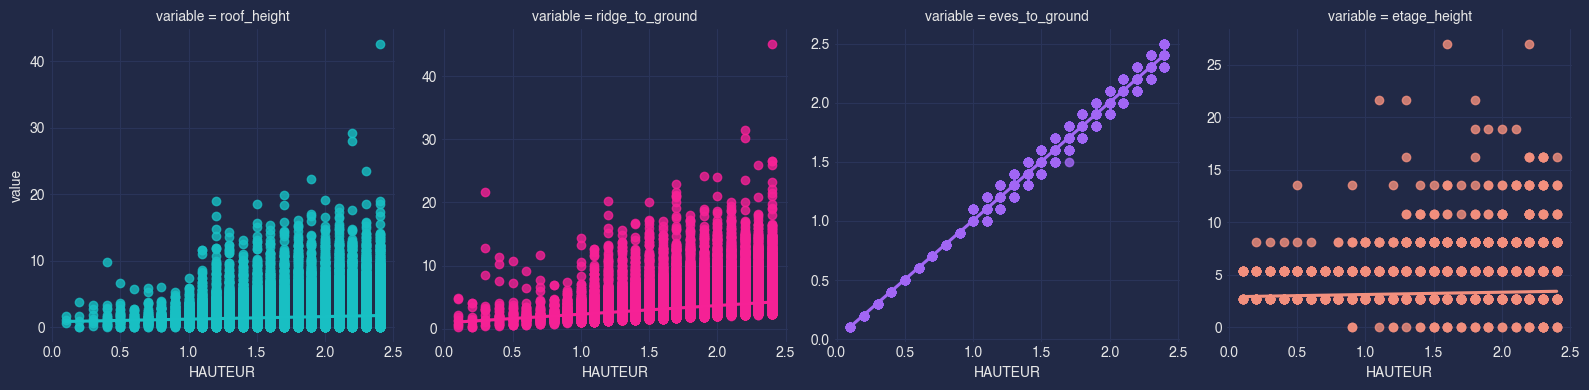

In [17]:
sns.lmplot(
    data=df_melt, x="HAUTEUR", y="value",
    col="variable", hue="variable", height=4, facet_kws={"sharey": False}
);

In [18]:
df_geoplot_sample = df_bretagne_25[df_bretagne_25.ridge_to_ground > 20.]
df_geoplot_sample

,HAUTEUR,ID,NB_ETAGES,ORIGIN_BAT,PREC_ALTI,Z_MAX_TOIT,Z_MIN_SOL,Z_MIN_TOIT,geometry,AREA,roof_height,ridge_to_ground,eves_to_ground,etage_height
136107,2.4,BATIMENT0000000087273746,NaN,Imagerie aérienne,1.5,98.7,72.2,NaN,"POLYGON Z ((286864.500 6789336.200 74.300, 286...",78.060,NaN,26.5,NaN,NaN
201391,1.2,BATIMENT0000000297235117,NaN,Cadastre,1.0,66.8,46.6,47.8,"POLYGON Z ((332507.800 6781611.700 47.800, 332...",28.690,19.0,20.2,1.2,NaN
240787,2.4,BATIMENT0000000297850261,NaN,Cadastre,2.5,121.4,100.4,102.8,"POLYGON Z ((344027.300 6805578.200 102.800, 34...",283.565,18.6,21.0,2.4,NaN
259506,2.4,BATIMENT0000000297109156,NaN,Cadastre,1.0,99.4,54.2,56.7,"POLYGON Z ((349740.100 6790577.500 56.700, 349...",104.390,42.7,45.2,2.5,NaN
263344,1.9,BATIMENT0000000297945461,NaN,Cadastre,1.0,108.9,84.7,86.6,"POLYGON Z ((350415.900 6774325.800 86.600, 350...",58.575,22.3,24.2,1.9,NaN
304405,1.7,BATIMENT0000000047080464,NaN,Imagerie aérienne,1.5,113.4,90.4,NaN,"POLYGON Z ((358666.000 6813749.000 92.000, 358...",106.670,NaN,23.0,NaN,NaN
305015,1.7,BATIMENT0000000047013008,NaN,Imagerie aérienne,1.5,27.4,6.3,NaN,"POLYGON Z ((358735.500 6844085.800 7.600, 3587...",25.360,NaN,21.1,NaN,NaN
344366,2.2,BATIMENT0000000047064697,NaN,Imagerie aérienne,1.5,127.7,104.1,NaN,"POLYGON Z ((372256.400 6818600.900 106.300, 37...",51.015,NaN,23.6,NaN,NaN
350241,2.4,BATIMENT0000000047061186,NaN,Imagerie aérienne,1.5,128.8,102.3,NaN,"POLYGON Z ((374143.100 6819550.600 104.700, 37...",96.990,NaN,26.5,NaN,NaN
360783,2.0,BATIMENT0000000297425614,NaN,Cadastre,1.0,121.7,100.6,102.6,"POLYGON Z ((378208.900 6820815.100 102.600, 37...",33.155,19.1,21.1,2.0,NaN


In [19]:
targets = df_geoplot_sample.sample(n=5, random_state=42)

## Buildings 

350241    POINT (-1.40424 48.39449)
dtype: geometry
500583    POINT (-1.07447 48.14770)
dtype: geometry
136107    POINT (-2.55176 48.07369)
dtype: geometry
2747461    POINT (-2.06585 48.53533)
dtype: geometry
386825    POINT (-1.18838 48.22734)
dtype: geometry


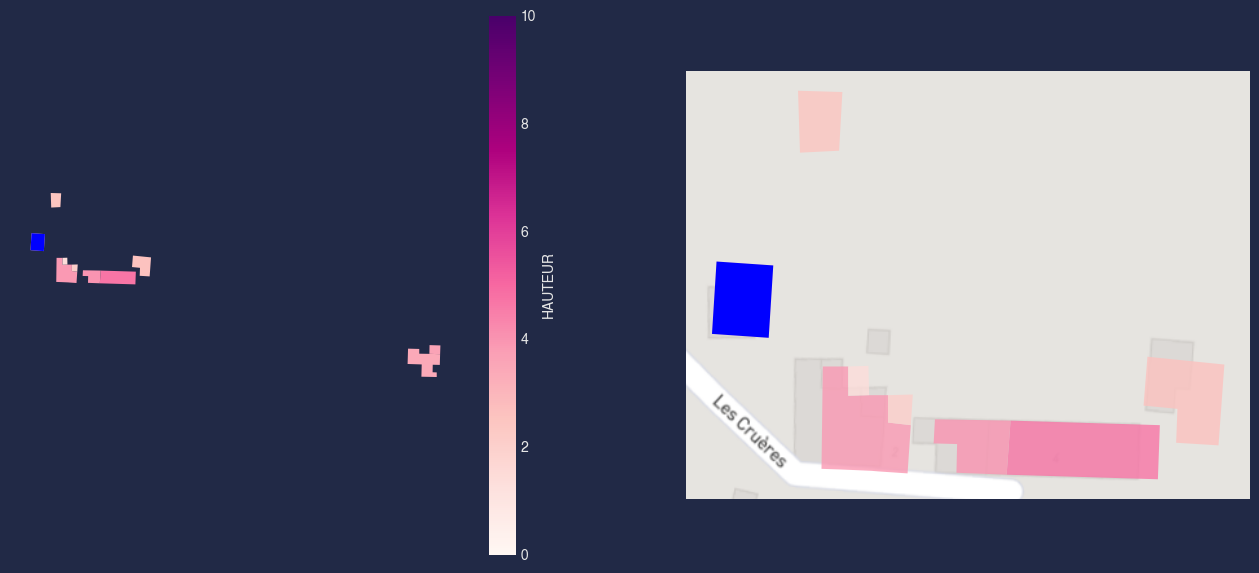

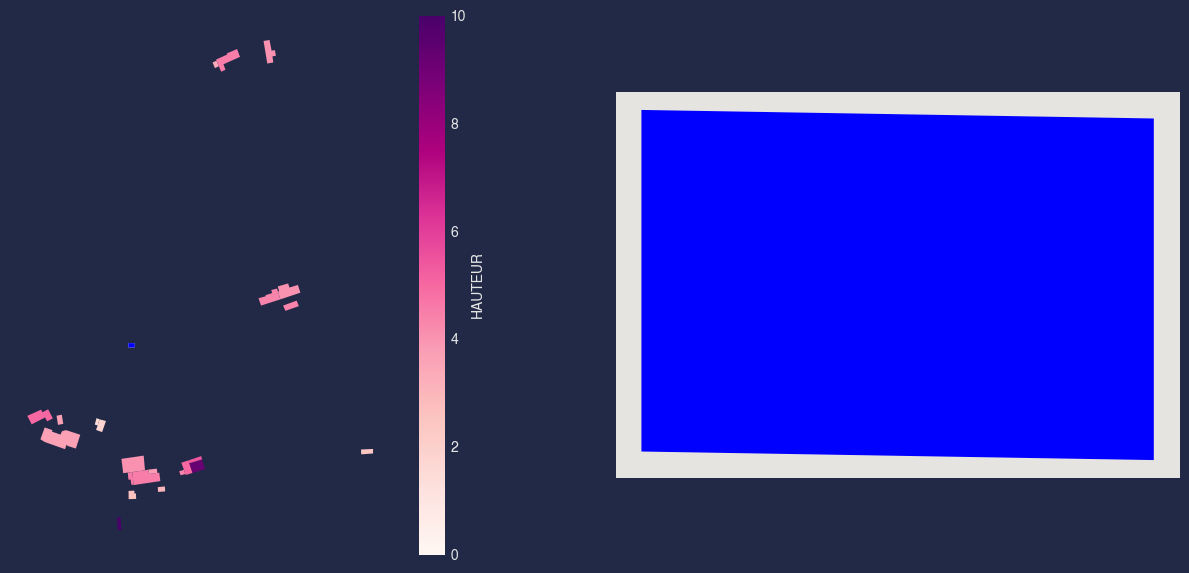

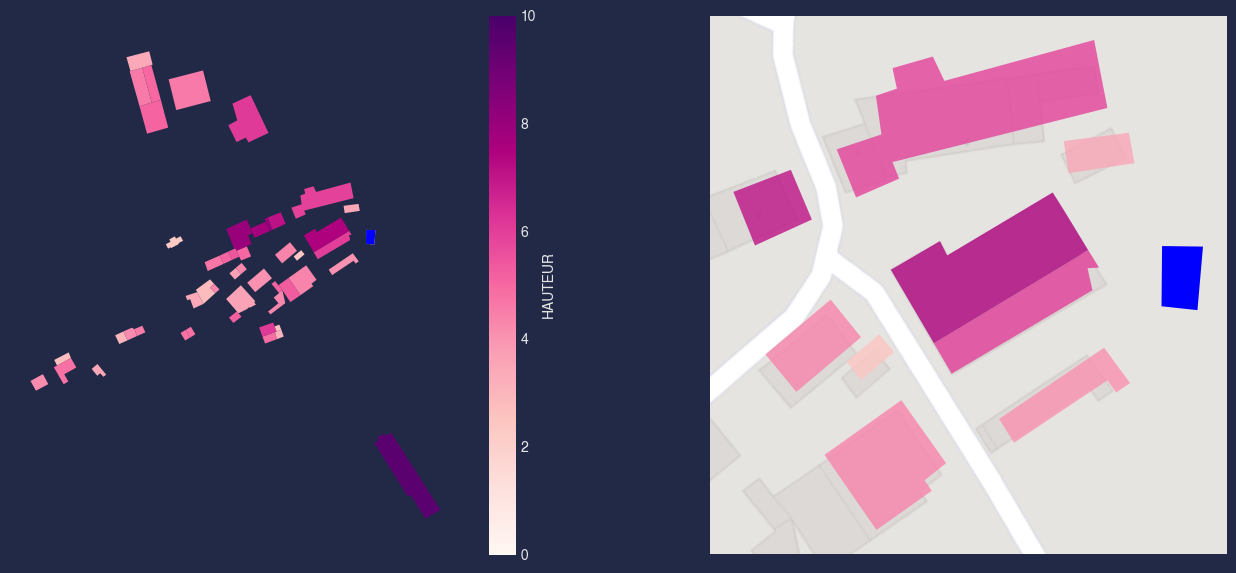

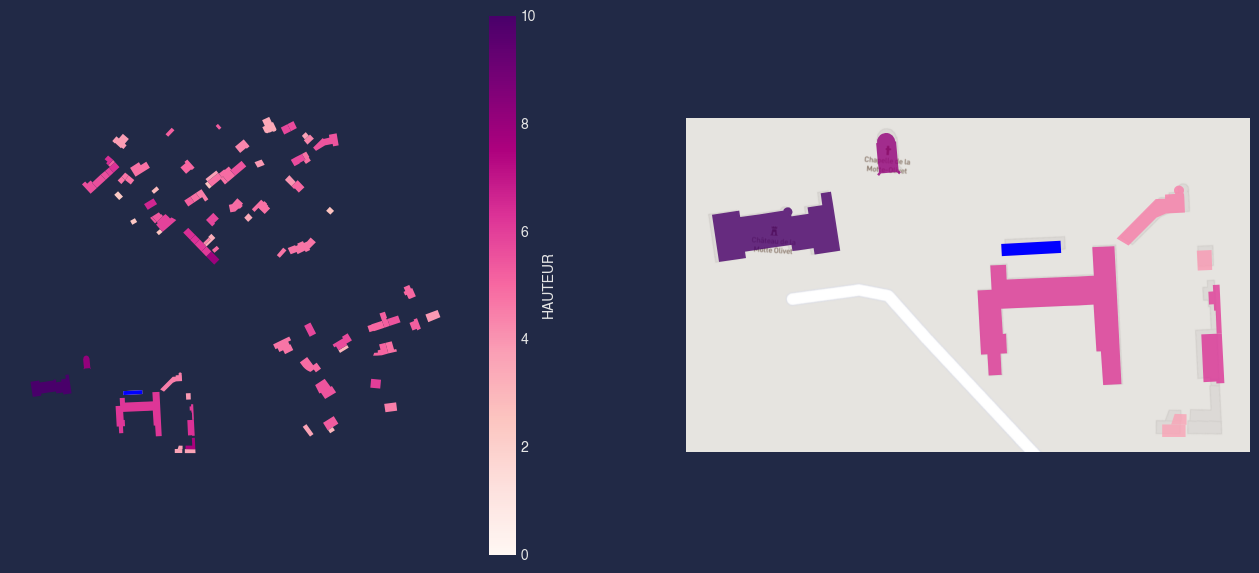

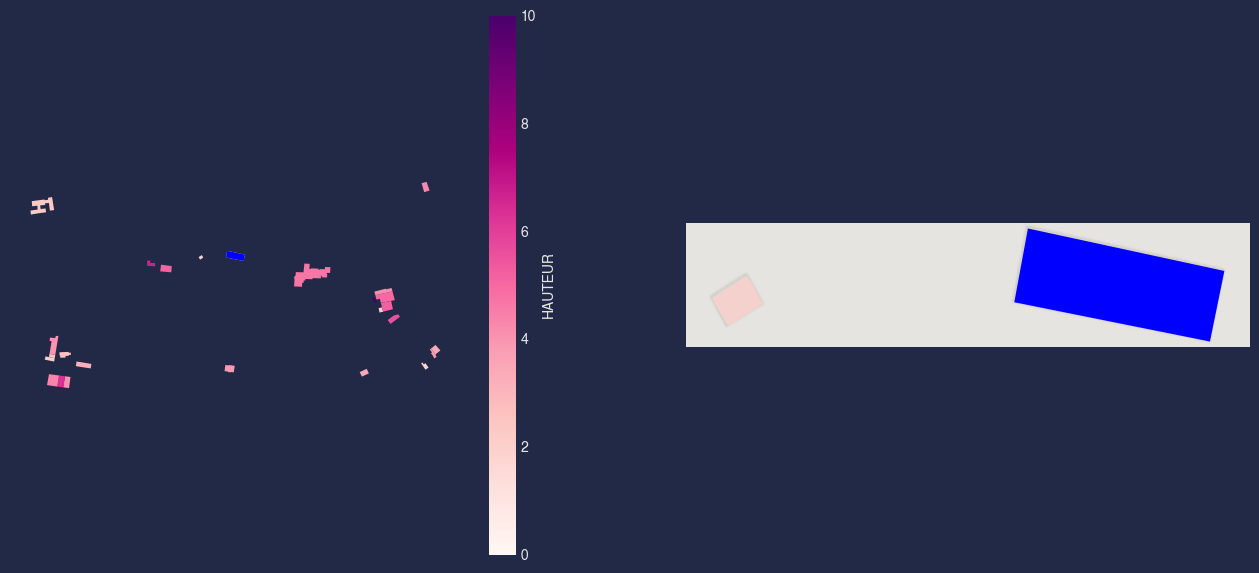

In [20]:
for i in range(5):
    src.plot_geo.compiled_plot(df=df_bretagne, target=targets.iloc[i:i+1], feature="HAUTEUR");

1. St Marc Le Blanc - Structure plus tree
![](./img/bretagne_001.png)

2. La Chapelle-Erbrée - Tree
![](./img/bretagne_002.png)

3. Forges de Lanouée - Structure plus tree
![](./img/bretagne_003.png)

4. Pleslin-Trigavou - Structure plus tree
![](./img/bretagne_004.png)

5. Châtillon-en-Vendelais - Structure (?) plus tree
![](./img/bretagne_005.png)

In [23]:
df_sample_etages = df_geoplot_sample[~df_geoplot_sample.NB_ETAGES.isna()]
df_sample_etages

,HAUTEUR,ID,NB_ETAGES,ORIGIN_BAT,PREC_ALTI,Z_MAX_TOIT,Z_MIN_SOL,Z_MIN_TOIT,geometry,AREA,roof_height,ridge_to_ground,eves_to_ground,etage_height
483345,2.4,BATIMENT0000000076291574,1.0,Imagerie aérienne,1.5,37.3,15.1,NaN,"POLYGON Z ((227723.000 6863098.700 17.500, 227...",61.540,NaN,22.2,NaN,2.7
2133008,2.4,BATIMENT0000000297082005,1.0,Cadastre,1.0,46.6,25.1,27.6,"POLYGON Z ((350861.900 6788759.400 27.600, 350...",38.435,19.0,21.5,2.5,2.7
2157053,2.2,BATIMENT0000000297121072,10.0,Cadastre,1.0,57.4,25.9,28.2,"POLYGON Z ((352682.100 6789155.600 28.200, 352...",742.805,29.2,31.5,2.3,27.0
2346410,1.7,BATIMENT0000000297659794,1.0,Cadastre,1.0,110.1,90.0,91.7,"POLYGON Z ((349919.800 6816730.500 91.700, 349...",52.470,18.4,20.1,1.7,2.7


483345    POINT (-3.42381 48.69510)
dtype: geometry
2133008    POINT (-1.69359 48.10576)
dtype: geometry
2157053    POINT (-1.66933 48.11047)
dtype: geometry
2346410    POINT (-1.72865 48.35641)
dtype: geometry


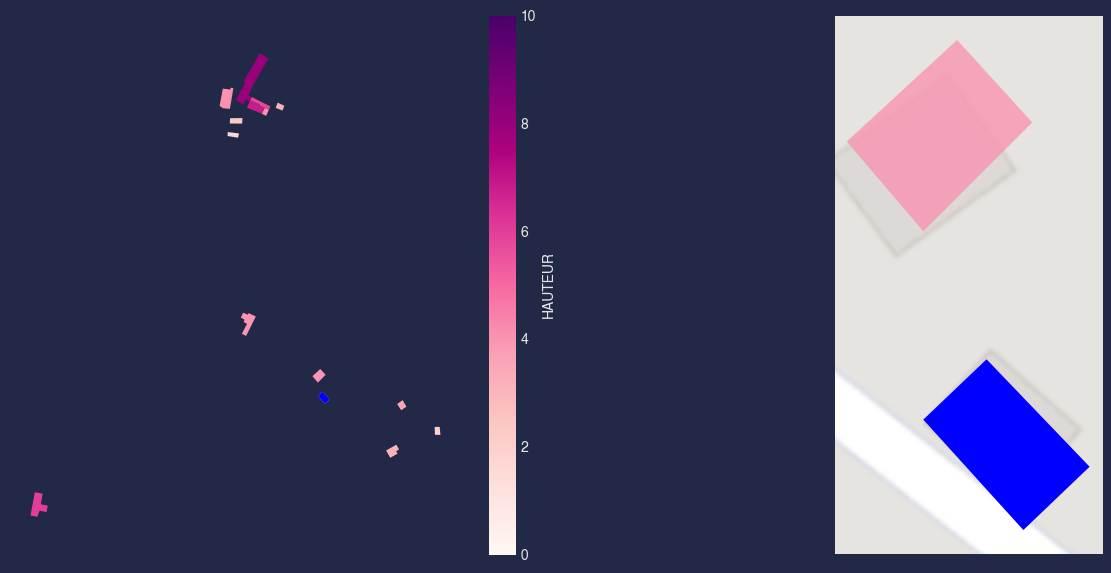

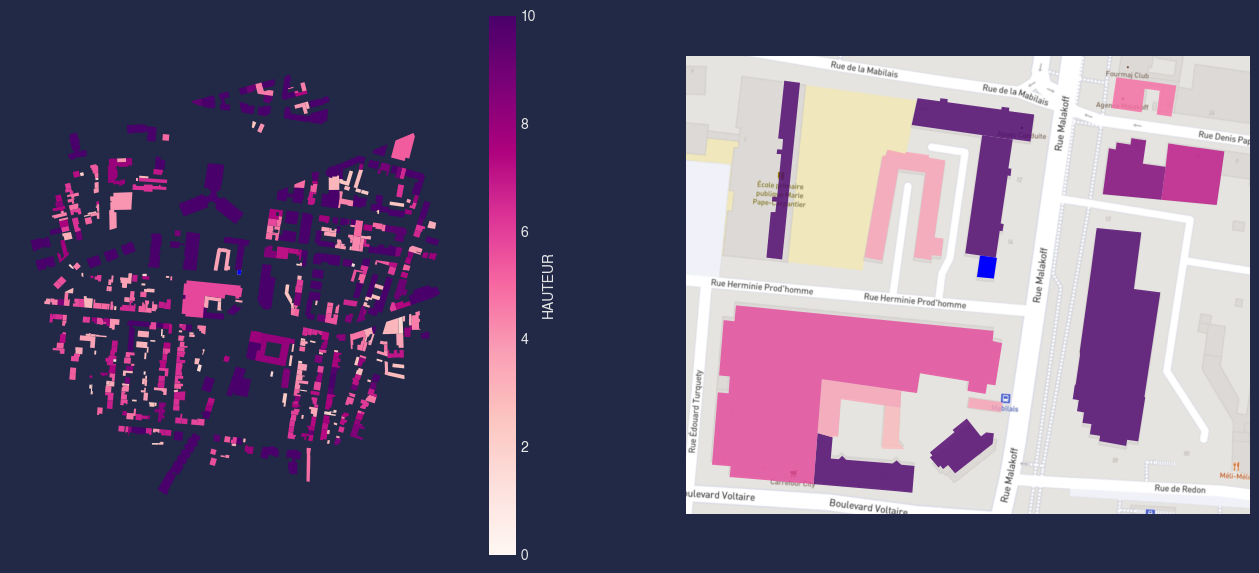

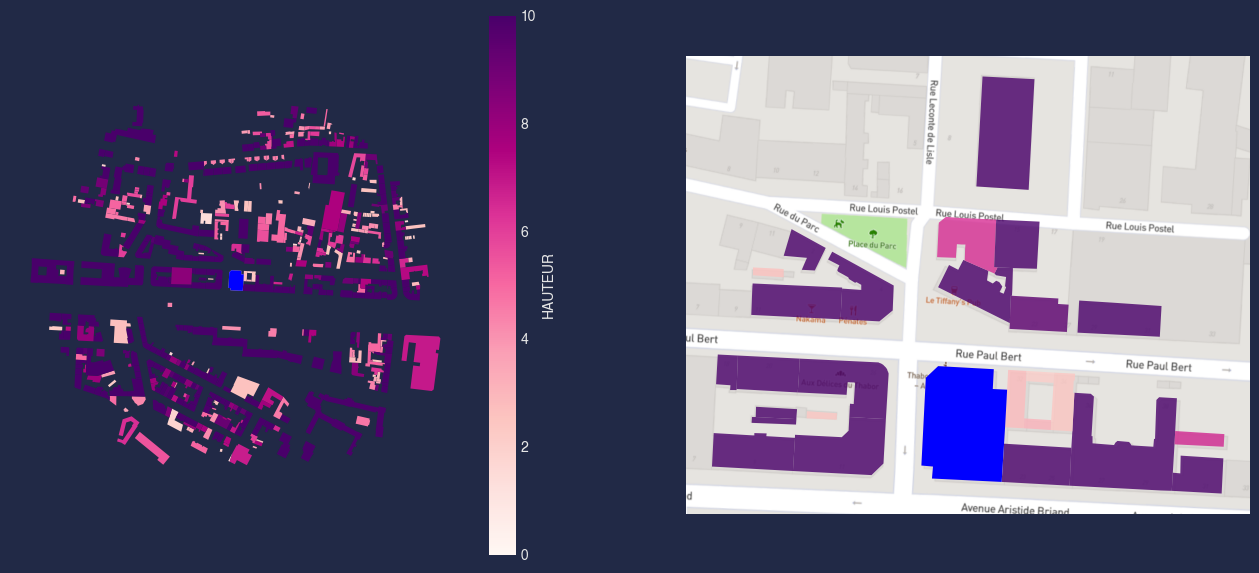

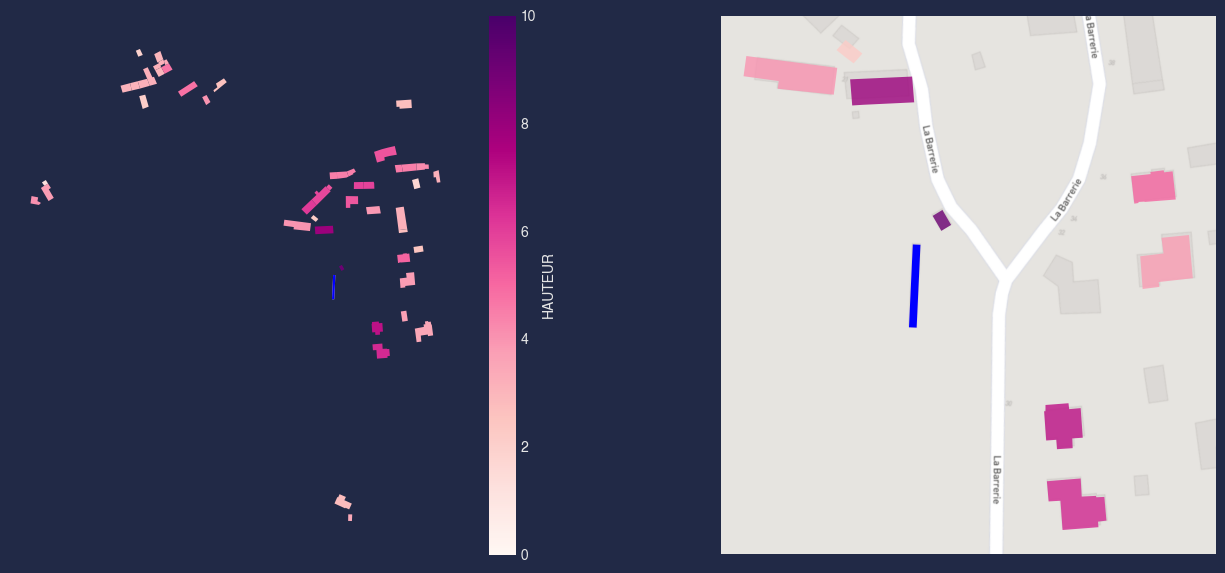

In [25]:
targets = df_sample_etages
for i in range(4):
    src.plot_geo.compiled_plot(df=df_bretagne, target=targets.iloc[i:i+1], feature="HAUTEUR");

6. Ploubezre - stone wall and tree?
![](./img/bretagne_006.png)

7. Rennes - low structure next to tall apartment block and tree
![](./img/bretagne_007a.png)
![](./img/bretagne_007b.png)

8. Rennes - tall apartment block, but car park has been merged into the building footprint
![](./img/bretagne_008a.png)
![](./img/bretagne_008b.png)


6. Dingé - tree and low structure
![](./img/bretagne_009.png)
